#  信用评分卡模型案例

## 1.业务理解

### 1.1 建模目的
基于客户数据，通过预测客户未来两年是否会陷入财务危机的概率来改善银行信用评分的质量。
### 1.2 业务背景
a、信用评分是指根据银行客户的各种历史信用资料，利用一定的信用评分模型，得到不同等级的信用分数，根据客户的信用分数，授信者可以通过分析客户按时还款的可能性，据此决定是否给予授信以及授信的额度和利率。虽然授信者通过人工分析客户的历史信用资料，同样可以得到这样的分析结果，但利用信用评分却更加快速、更加客观、更具有一致性。

b、本次要建立的信用评分卡属于信用评分卡中的A卡（Application score card）即申请评分卡，是客户贷款前对客户实行打分制，以期对客户有一个优质与否的评判。

## 2.数据理解阶段

### 2.1 数据来源
本次建模数据来自Kaggle竞赛网的Give Me Some Credit数据集，该数据集收集了15万条个体客户的基本信息，其中12万条训练集数据，3万条测试集数据。数据集中的包含10个字段，其中一个为目标字段，下表展示了各个字段的含义。
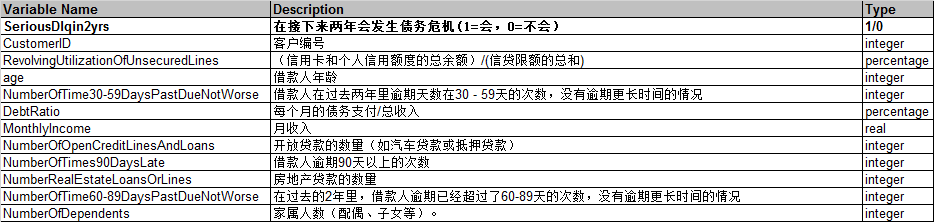

### 2.2 字段理解
根据业务的背景，可以上客户信息分为以下几类：

基本信息：age

负债信息:RevolvingUtilizationOfUnsecuredLines、DebtRatio、NumberOfOpenCreditLinesAndLoans、NumberRealEstateLoansOrLines

偿还能力：MonthlyIncome

历史信用记录：NumberOfTime30-59DaysPastDueNotWorse、NumberOfTime60-89DaysPastDueNotWorse、NumberOfTimes90DaysLate

人际社交信息：NumberOfDependents

## 3.数据预处理

### 3.1 读取数据

In [1]:
#导入数据预处理所需要的工具包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

#导入统计学常用数据包
from scipy import stats
from scipy.stats import norm, skew 

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #忽略警告
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #设置pandas输出数据为3位小数

In [2]:
#导入测试集与训练集
train = pd.read_csv('cs-training.csv')
test = pd.read_csv('cs-test v2.csv')

In [3]:
#数据基本信息
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 12 columns):
CustomerID                              120000 non-null int64
RevolvingUtilizationOfUnsecuredLines    120000 non-null float64
age                                     120000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    120000 non-null int64
DebtRatio                               120000 non-null float64
MonthlyIncome                           96224 non-null float64
NumberOfOpenCreditLinesAndLoans         120000 non-null int64
NumberOfTimes90DaysLate                 120000 non-null int64
NumberRealEstateLoansOrLines            120000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    120000 non-null int64
NumberOfDependents                      116860 non-null float64
SeriousDlqin2yrs                        120000 non-null int64
dtypes: float64(4), int64(8)
memory usage: 11.0 MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
CustomerID                              30000 non-null int64
RevolvingUtilizationOfUnsecuredLines    30000 non-null float64
age                                     30000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    30000 non-null int64
DebtRatio                               30000 non-null float64
MonthlyIncome                           24045 non-null float64
NumberOfOpenCreditLinesAndLoans         30000 non-null int64
NumberOfTimes90DaysLate                 30000 non-null int64
NumberRealEstateLoansOrLines            30000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    30000 non-null int64
NumberOfDependents                      29216 non-null float64
SeriousDlqin2yrs                        30000 non-null int64
dtypes: float64(4), int64(8)
memory usage: 2.7 MB


### 3.2 合并训练集与测试集
训练集与测试集中数据包含的字段完全一致，都为10个数值型变量和一个目标变量，因此可以统一的预处理

In [5]:
#保存ID号码
train_ID = train['CustomerID']
test_ID = test['CustomerID']

#合并训练集和测试集
y_train = train.SeriousDlqin2yrs
y_test = test.SeriousDlqin2yrs
all_data = pd.concat((train, test)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (150000, 12)


### 3.3 重复值处理
训练集数据高达12万条，很大概率含有重复值，先将重复值去除。

In [6]:
#检查数据
print("处理前数据大小 : {} ".format(all_data.shape))

#获取去重复的字段名列表
cols_df = all_data.columns.values.tolist()
cols_df.remove('CustomerID')

#去除训练数据中的重复值
all_data.drop_duplicates(subset = cols_df, inplace=True)

#检查数据
print("处理后数据大小 : {} ".format(all_data.shape))

处理前数据大小 : (150000, 12) 
处理后数据大小 : (149391, 12) 


### 3.4 缺失值处理

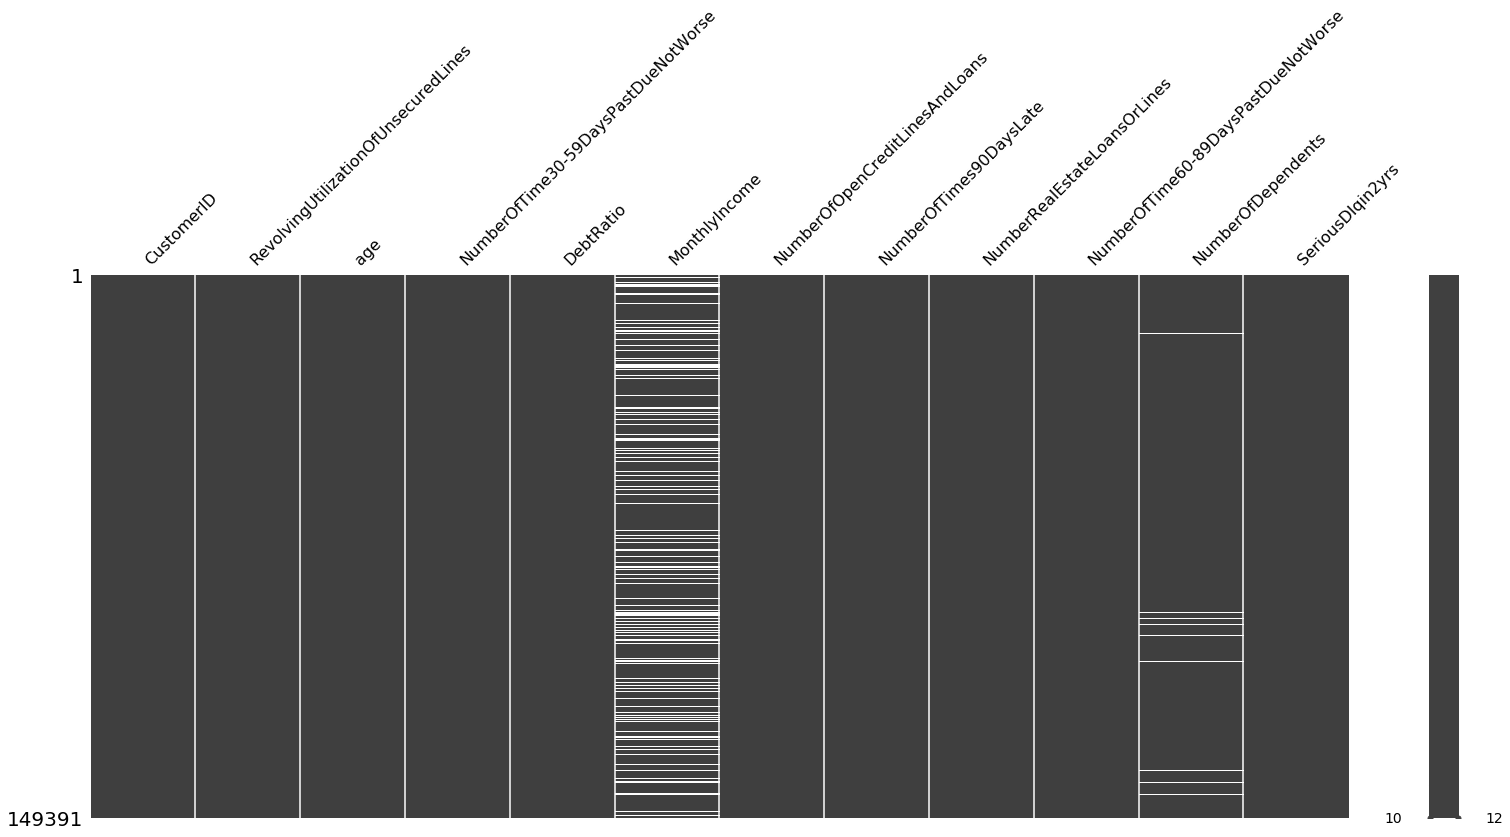

In [7]:
import missingno as msno
msno.matrix(all_data)

In [8]:
all_data.isnull().mean()

CustomerID                             0.000
RevolvingUtilizationOfUnsecuredLines   0.000
age                                    0.000
NumberOfTime30-59DaysPastDueNotWorse   0.000
DebtRatio                              0.000
MonthlyIncome                          0.196
NumberOfOpenCreditLinesAndLoans        0.000
NumberOfTimes90DaysLate                0.000
NumberRealEstateLoansOrLines           0.000
NumberOfTime60-89DaysPastDueNotWorse   0.000
NumberOfDependents                     0.026
SeriousDlqin2yrs                       0.000
dtype: float64

NumberOfDependents存在缺失值,缺失率为0.026，因此直接删除缺失值。

In [9]:
#检查数据
print("处理前数据集大小 : {} ".format(all_data.shape))

all_data.dropna(subset=['NumberOfDependents'],inplace=True)

#检查数据
print('--------------------------------')
print("处理后数据集大小 : {} ".format(all_data.shape))

处理前数据集大小 : (149391, 12) 
--------------------------------
处理后数据集大小 : (145563, 12) 


Monthlyincome，缺失率为0.196，缺失的数据较多，不能直接删除含有缺失值的记录，后面根据其分布特征选择缺失值填补方法。

## 4.数据探索

### 4.1 单变量探索

In [10]:
# 本次单变量探索用到的字定义函数
##分位法处理异常值
def IQR_Cleaner(df,atrribute_name,floor,ceiling,method):
    ##df：要清洗的DataFrame，DataFrame
    ##atrribute_name：清洗的属性名称，字符串
    ##floor：清洗的下分位数，float
    ##ceiling：清洗的上分位数，float
    ##method:'drop' 或者 ‘fill’
    Q1 = df[atrribute_name].quantile(floor)
    Q3 = df[atrribute_name].quantile(ceiling)
    IQR = Q3 - Q1
    down = Q1 - 1.5*IQR
    up = Q3 + 1.5*IQR
    if method == 'drop':
        df = df.loc[(df[atrribute_name]<up) & (df[atrribute_name]>down),:]
    else:
        df.loc[df[atrribute_name]>up,atrribute_name]=up
        df.loc[df[atrribute_name]<down,atrribute_name]=down
    return df

##单变量分布可视化函数
def Distribution_worker(target,bins):
    ## target 需要探索的单变量
    ## 直方图
    fig = plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(target, fit=norm, bins=bins)
    (mu, sigma) = norm.fit(target)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
    plt.ylabel('Frequency')
    plt.title('distribution')
    
    ##箱线图
    plt.subplot(122)
    sns.boxplot(y =target , width=0.2)

### age字段
1）从直方图来看age字段分布几乎没有偏斜。
2）从箱线图来看age字段有部分异常值，我们用天花板法，将超出1.5倍IQR距离的数值赋值为领临界值。

C:\Users\sinopec\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 52.11 and sigma = 14.57



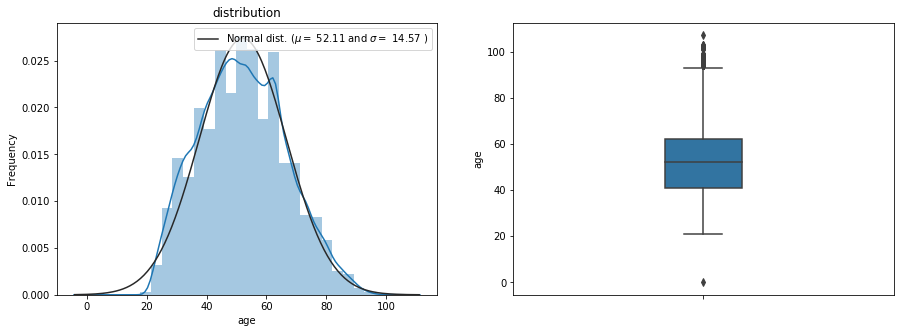

In [11]:
#输入目标变量
target = all_data.age

#变量分布特征
Distribution_worker(target,30)


 mu = 52.11 and sigma = 14.56



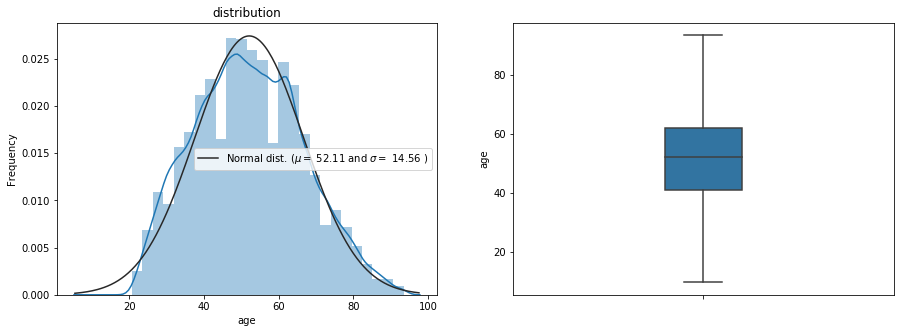

In [12]:
#异常值处理
all_data = IQR_Cleaner(all_data, 'age', 0.25, 0.75, 'fill')

#输入目标变量
target = all_data.age

#处理后变量分布特征
Distribution_worker(target,30)

### RevolvingUtilizationOfUnsecuredLines 字段


 mu = 5.94 and sigma = 250.51



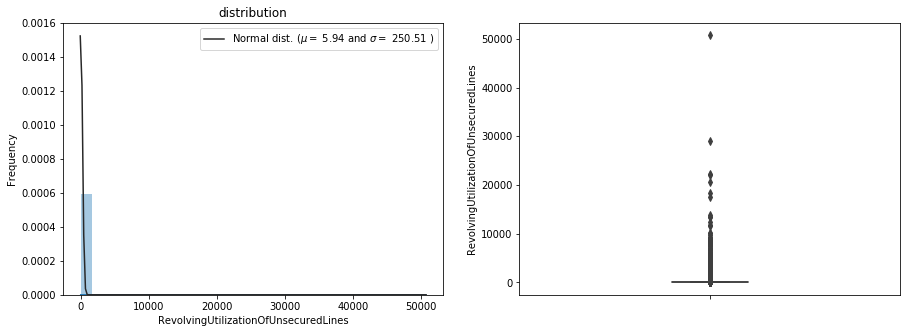

In [13]:
#输入目标变量
target = all_data.RevolvingUtilizationOfUnsecuredLines

#变量分布特征
Distribution_worker(target,30)

 RevolvingUtilizationOfUnsecuredLines字段大于1的记录占比: 0.02726048818015336 

 mu = 0.31 and sigma = 0.34



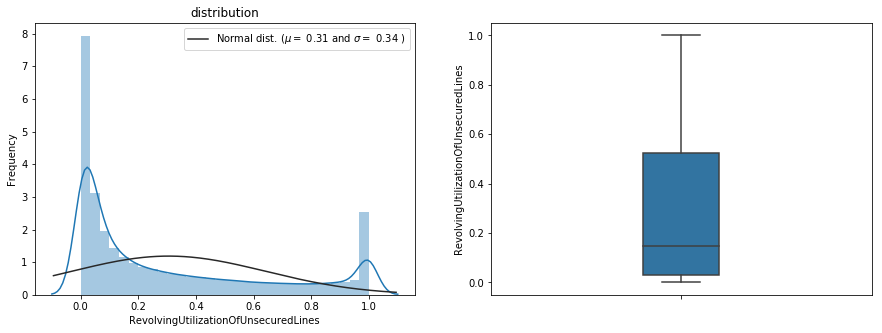

In [14]:
#异常值处理
outlier_num  = all_data.loc[all_data.RevolvingUtilizationOfUnsecuredLines>1].shape[0]
print(" RevolvingUtilizationOfUnsecuredLines字段大于1的记录占比: {} ".format(outlier_num/119587)) 

#大于1的记录赋值为1
all_data = all_data.loc[all_data.RevolvingUtilizationOfUnsecuredLines<=1]

#处理后字段分布特征

#输入目标变量
target = all_data.RevolvingUtilizationOfUnsecuredLines

#变量分布特征
Distribution_worker(target,30)

### DebtRatio 字段


 mu = 336.96 and sigma = 1964.39



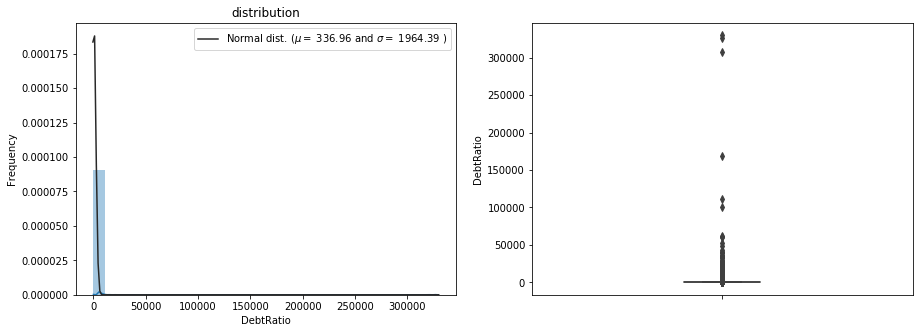

In [15]:
#输入目标变量
target = all_data.DebtRatio

#变量分布特征
Distribution_worker(target,30)

 DebtRatio字段大于1的记录占比: 0.259442916036024 

 mu = 0.59 and sigma = 0.58



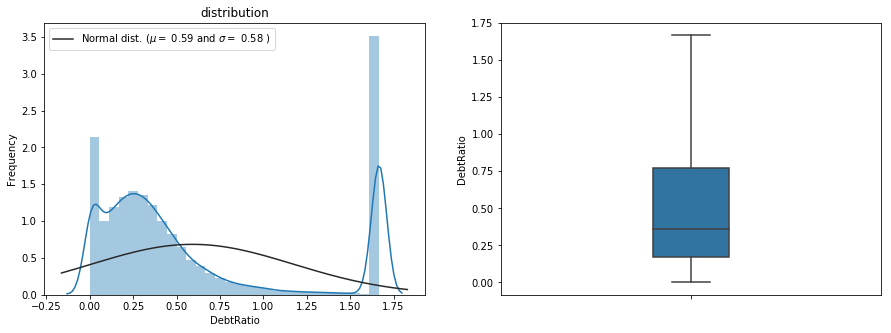

In [16]:
#异常值处理
outlier_num  = all_data.loc[all_data.DebtRatio>1].shape[0]
print(" DebtRatio字段大于1的记录占比: {} ".format(outlier_num/119587)) 

#天花板法处理异常值
all_data = IQR_Cleaner(all_data, 'DebtRatio', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = all_data.DebtRatio

#变量分布特征
Distribution_worker(target,30)

### NumberOfOpenCreditLinesAndLoans 字段


 mu = 8.60 and sigma = 5.15



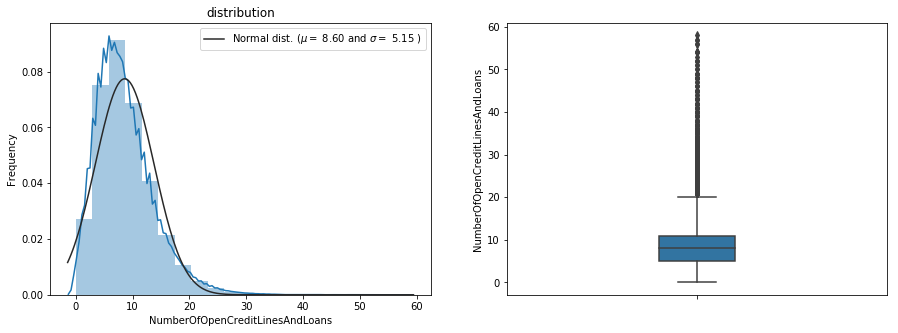

In [17]:
#输入目标变量
target = all_data.NumberOfOpenCreditLinesAndLoans

#变量分布特征
Distribution_worker(target,20)


 mu = 8.47 and sigma = 4.73



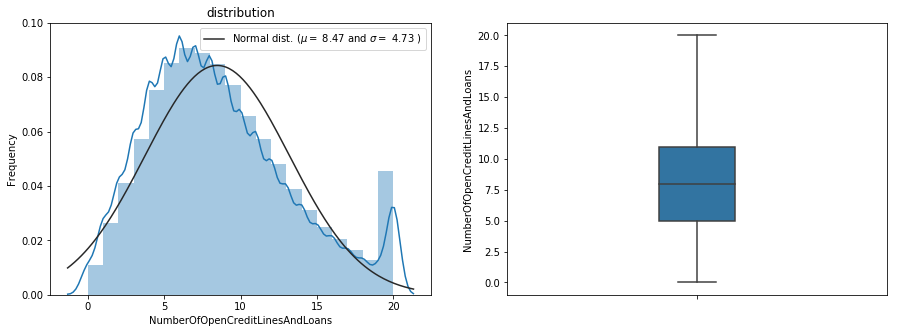

In [18]:
#天花板法处理异常值
all_data = IQR_Cleaner(all_data, 'NumberOfOpenCreditLinesAndLoans', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = all_data.NumberOfOpenCreditLinesAndLoans

#变量分布特征
Distribution_worker(target,20)

### NumberRealEstateLoansOrLines 字段


 mu = 1.04 and sigma = 1.14



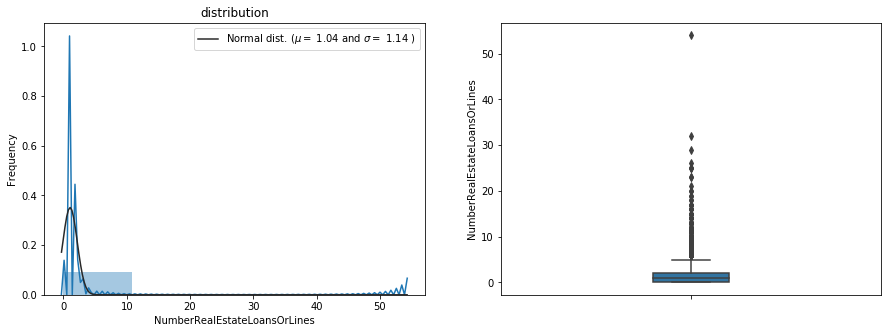

In [19]:
#输入目标变量
target = all_data.NumberRealEstateLoansOrLines

#变量分布特征
Distribution_worker(target,5)


 mu = 1.03 and sigma = 1.02



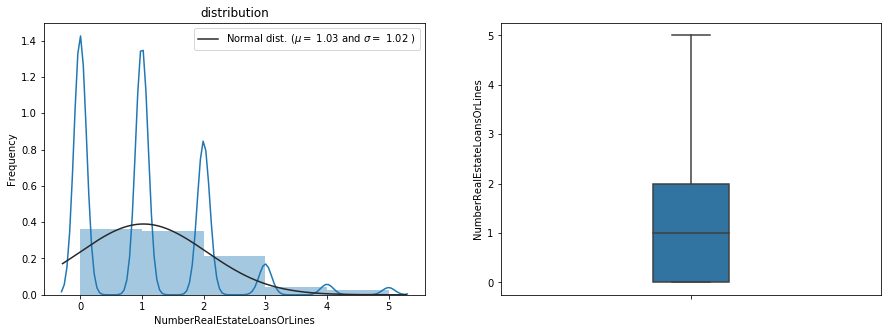

In [20]:
#天花板法处理异常值
all_data = IQR_Cleaner(all_data, 'NumberRealEstateLoansOrLines', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = all_data.NumberRealEstateLoansOrLines

#变量分布特征
Distribution_worker(target,5)

### NumberOfDependents 字段


 mu = 0.76 and sigma = 1.11



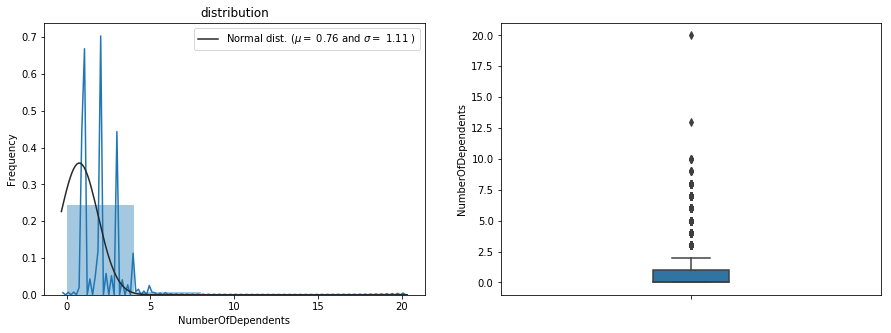

In [21]:
#输入目标变量
target = all_data.NumberOfDependents

#变量分布特征
Distribution_worker(target,5)


 mu = 0.68 and sigma = 0.91



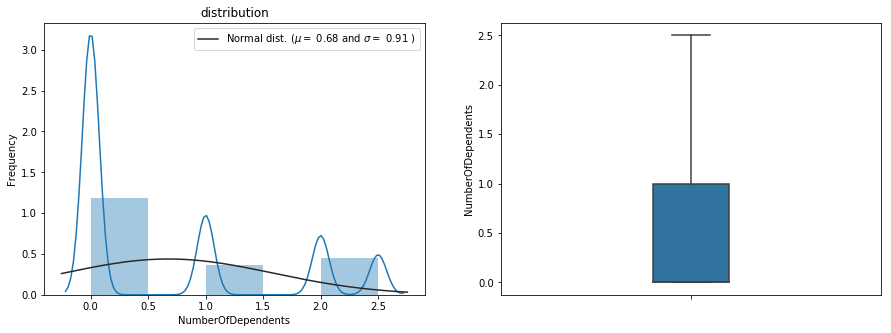

In [22]:
#天花板法处理异常值
all_data = IQR_Cleaner(all_data, 'NumberOfDependents', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = all_data.NumberOfDependents

#变量分布特征
Distribution_worker(target,5)

#### NumberOfTime30-59DaysPastDueNotWorse、NumberOfTime60-89DaysPastDueNotWorse、NumberOfTimes90DaysLate 字段

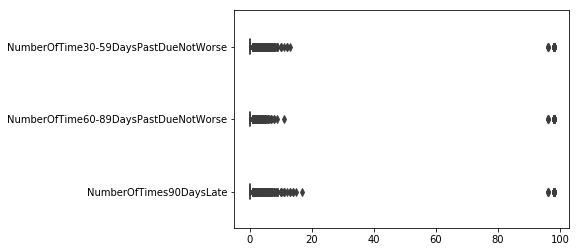

In [23]:
##观察历史信用记录数据分布情况
target = all_data[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']]
sns.boxplot(data =target, width=0.2,orient='h')

In [24]:
#大于20的值赋值为20
all_data.loc[all_data['NumberOfTime30-59DaysPastDueNotWorse']>20,'NumberOfTime30-59DaysPastDueNotWorse']=20
all_data.loc[all_data['NumberOfTime60-89DaysPastDueNotWorse']>20,'NumberOfTime60-89DaysPastDueNotWorse']=20
all_data.loc[all_data['NumberOfTimes90DaysLate']>20,'NumberOfTimes90DaysLate']=20

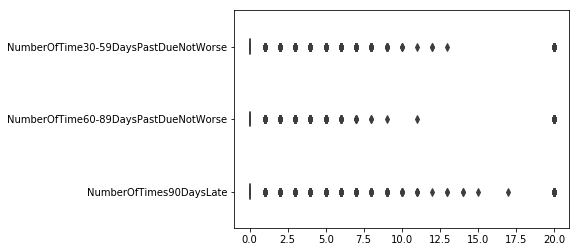

In [25]:
##观察历史信用记录数据分布情况
target = all_data[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']]
sns.boxplot(data =target, width=0.2,orient='h')

### MonthlyIncome 字段


 mu = 6707.83 and sigma = 14535.49



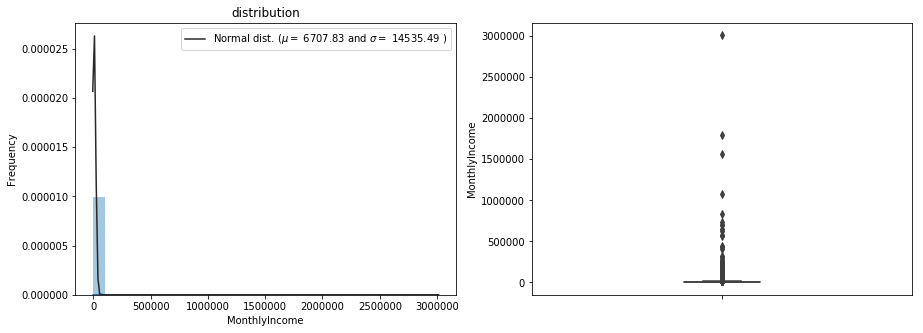

In [26]:
#输入目标变量
target = all_data.dropna().MonthlyIncome

#变量分布特征
Distribution_worker(target,30)


 mu = 6192.60 and sigma = 3760.88



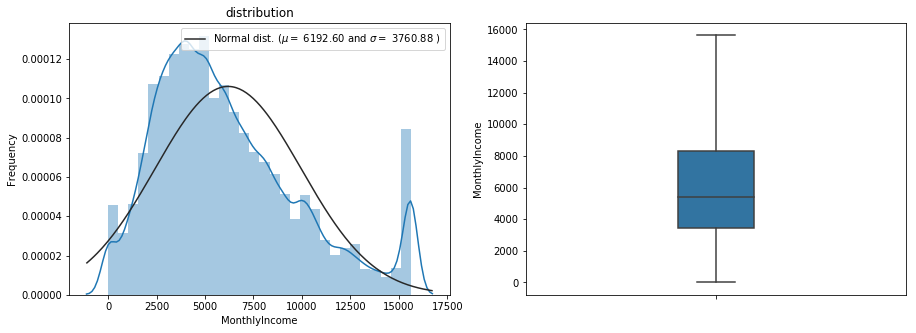

In [27]:
#天花板法处理异常值
all_data = IQR_Cleaner(all_data, 'MonthlyIncome', 0.25, 0.75, 'fill')

#处理后字段分布特征

#输入目标变量
target = all_data.dropna().MonthlyIncome

#变量分布特征
Distribution_worker(target,30)

In [28]:
from sklearn.ensemble import RandomForestRegressor

def fill_missing(data, to_fill):
    df = data.copy()
    columns = [*df.columns]
    columns.remove(to_fill)
    
    # 移除有缺失值的列
    columns.remove('NumberOfDependents')
    columns.remove('CustomerID')
    columns.remove('SeriousDlqin2yrs')
    X = df.loc[:, columns]
    y = df.loc[:, to_fill]
    X_train = X.loc[df[to_fill].notnull()]
    y_train = y.loc[df[to_fill].notnull()]
    X_pred = X.loc[df[to_fill].isnull()]
    rfr = RandomForestRegressor(random_state=22, n_estimators=100, max_depth=3, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_pred).round()
    df.loc[df[to_fill].isnull(), to_fill] = y_pred
    return df

C:\Users\sinopec\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 5370.26 and sigma = 3882.48



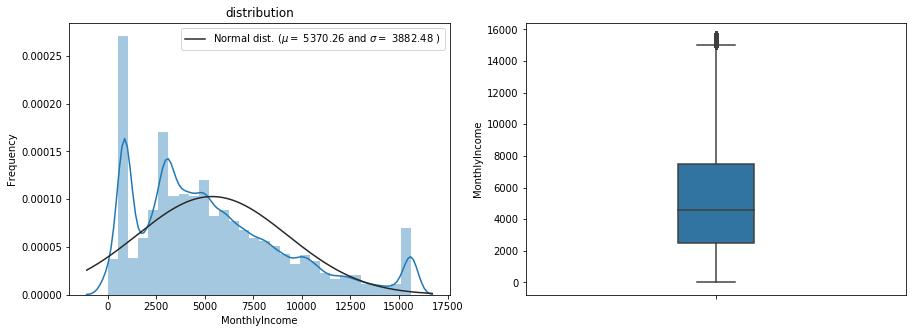

In [29]:
all_data = fill_missing(all_data, 'MonthlyIncome')

#输入目标变量
target = all_data.MonthlyIncome

#变量分布特征
Distribution_worker(target,30)

### 4.2 数据间关系探索

age


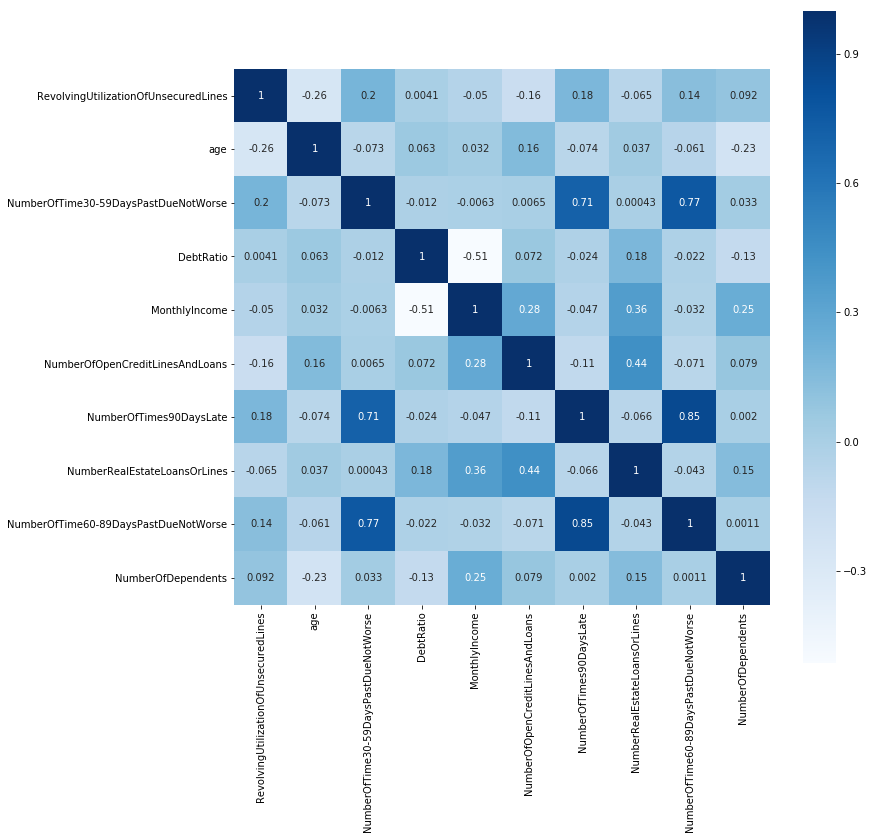

In [30]:
corr = all_data.drop(['CustomerID','SeriousDlqin2yrs'],axis=1).corr()
print(max(corr))
plt.subplots(figsize=(12, 12))
sns.heatmap(corr, annot=True, vmax=1, square=True, cmap='Blues')

##  5 数据建模

#### 5.1 拆分训练集与测试集

In [32]:
# 训练集与测试集划分
test_data = all_data.loc[all_data.CustomerID>120000,:]
train_data = all_data.loc[all_data.CustomerID<=120000,:]
y_train = train_data['SeriousDlqin2yrs'].values
X_train = train_data.drop(['CustomerID','SeriousDlqin2yrs'],axis=1).values
y_test = test_data['SeriousDlqin2yrs'].values
X_test = test_data.drop(['CustomerID','SeriousDlqin2yrs'],axis=1).values

print("X_train size is : {}".format(X_train.shape))
print("y_train size is : {}".format(y_train.shape))
print("X_test size is : {}".format(X_test.shape))
print("y_test size is : {}".format(y_test.shape))

#### 5.2 模型参数优化

In [1]:
# 导入xgboost库与网格搜索库
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
#设置交叉验证次数
cv_num = 5
score_method = 'roc_auc'

In [ ]:
#记录模型训练起始时间
time0 = time.time() 

模型训练时常用的评分指标：accuracy, balanced_accuracy, average_precision, brier_score_loss, f1, f1_micro, f1_weighted, f1_samples, neg_log_loss, precision,recall, roc_auc.

In [ ]:
#scale_pos_weight 调参
cv_params = {'scale_pos_weight':[2,4,6,8,9,10,15,20,30]}
xgbc = XGBClassifier(nthread=-1,n_jobs=-1, random_state=222, objective = 'binary:logistic',n_estimators=10)
gs = GridSearchCV(xgbc, param_grid=cv_params, scoring=score_method, cv=cv_num, n_jobs=-1,)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
# n_estimators 调参
cv_params = {'n_estimators': [10,20,50,100,200,300]}
xgbc = gs.best_estimator_
gs = GridSearchCV(xgbc, param_grid=cv_params, scoring=score_method, cv=cv_num, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
# max_depth，min_child_weight 调参
cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
xgbc = gs.best_estimator_
gs = GridSearchCV(xgbc, param_grid=cv_params, scoring=score_method, cv=cv_num, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
# gamma 调参
cv_params = {'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
xgbc = gs.best_estimator_
gs = GridSearchCV(xgbc, param_grid=cv_params, scoring=score_method, cv=cv_num, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
# subsample，colsample_bytree 调参
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
xgbc = gs.best_estimator_
gs = GridSearchCV(xgbc, param_grid=cv_params, scoring=score_method, cv=cv_num, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
# learning_rate 调参
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
xgbc = gs.best_estimator_
gs = GridSearchCV(xgbc, param_grid=cv_params, scoring=score_method, cv=cv_num, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
#参数优化后的模型
gs.best_estimator_

In [ ]:
#训练模型所用时长
time_ = time.time()-time0
print(time/60)

In [ ]:
# 使用最优参组合训练模型
xgbc = gs.best_estimator_
xgbc.fit(X_train, y_train)

In [ ]:
# 保存模型
from sklearn.externals import joblib
joblib.dump(xgbc, "pima.joblib.dat")
# 读取模型
xgbc = joblib.load("pima.joblib.dat")

In [ ]:
# 利用训练好的模型预测结果
y_prob_test = xgbc.predict_proba(X_test)
y_prob_train = xgbc.predict_proba(X_train)

## 6 模型评估

In [ ]:
# 导入模型评估常用的库
from sklearn import metrics as ME

### 6.1 模型准确度评估

In [ ]:
resu = y_prob_test[:, 1]
fpr, tpr, threshold = ME.roc_curve(y_test, resu)
rocauc = ME.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % rocauc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

AUC(area under curve), 这里的AUC是ROC曲线下的面积，通常介于0.5和1之间，可以直观的评价分类器的好坏。

AUC低于0.5，区分度弱于随机猜测，0.5~0.6有较弱的区分度，0.6~0.7，有一定的区分度，>0.7有很强的区分度。

### 6.2 模型区分度评估

In [ ]:
KS = max(tpr-fpr)
thread_max = threshold[np.argmax(tpr-fpr)]
print('position of ks:', (thread_max, KS))
plt.plot(threshold, tpr, 'b', label='tpr')
plt.plot(threshold, fpr, 'r', label='fpr')
plt.plot(threshold, tpr-fpr, 'g--', label='KS : %0.3f' % KS)
plt.legend(loc='upper right')
plt.ylabel('tpr&fpr')
plt.xlabel('thread')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

KS（Kolmogorov-Smirnov）是衡量模型区分能力常用的一个指标。

KS<0评分与好坏程度相悖，模型错误，0~0.2模型较差，0.2~0.3可用，>0.3好。

### 6.3 模型稳定性评估

In [ ]:
train_data = pd.DataFrame({'train': y_prob_train[:, 0]})
test_data = pd.DataFrame({'test': y_prob_test[:, 0]})
result_train, bins = pd.cut(train_data.train, bins=10, retbins=True)  # 将训练集数据按照预测分数分成10组
result_test = pd.cut(test_data.test, bins=bins)  # 按照训练集分组把测试集预测分数也分成10组
psi_train = result_train.value_counts()
psi_test = result_test.value_counts()
psi_train = psi_train/psi_train.sum()
psi_test = psi_test/psi_test.sum()
psi = ((psi_test - psi_train)*np.log((psi_test/psi_train))).sum()
print("The PSI of the model is : {:.3f}".format(psi))

PSI（population stability index） 计算公式：
PSI = sum(（实际占比-预期占比）* ln(实际占比/预期占比))

PSI小于0.1时候模型稳定性很高，0.1-0.2一般，需要进一步研究，大于0.2模型稳定性差，建议修复。